<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [224]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [225]:
import re
import os
import gdown
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN, Activation, Dropout, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from IPython.display import clear_output


In [226]:
# Descargar la carpeta de dataset
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [227]:
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

In [228]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [229]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

# Procesar el dataset
for line in data:
    for i in range(len(line['dialog'])-1):
        # Separar el texto en "preguntas" (chat_in) y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        # Saltar oraciones que excedan la longitud máxima
        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # Agregar <eos> (end of sentence) al final de la oración de salida
        output_sentence = output + ' <eos>'
        # Agregar <sos> (start of sentence) al inicio de la oración de entrada
        output_sentence_input = '<sos> ' + output

        # Añadir las oraciones a las listas correspondientes
        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de filas:", len(input_sentences))

Cantidad de filas: 6033


In [230]:
input_sentences[8], output_sentences[8], output_sentences_inputs[8]

('i am from russia and you ',
 'i am from the united states  <eos>',
 '<sos> i am from the united states ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [231]:
# Tokenizar las oraciones de entrada
tok_input = Tokenizer()
tok_input.fit_on_texts(input_sentences)

# Convertir las oraciones a secuencias de enteros
tokenized_input_sentences = tok_input.texts_to_sequences(input_sentences)
len(tokenized_input_sentences)

6033

In [232]:
word2idx_input = tok_input.word_index
print(f"El vocabulario de entrada tiene {len(word2idx_input)} palabras.")

El vocabulario de entrada tiene 1799 palabras.


In [233]:
max_input_len = len(max(tokenized_input_sentences, key=len))
print(f"La secuenca de entrada mas larga es: {max_input_len}")

La secuenca de entrada mas larga es: 9


In [234]:
# Tokenizar las oraciones de salida
tok_output = Tokenizer(filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
tok_output.fit_on_texts(["<sos>","<eos>"] + output_sentences)

# Convertir las oraciones de salida a secuencias de enteros
tokenized_output_input = tok_output.texts_to_sequences(output_sentences_inputs)
tokenized_output_sentences = tok_output.texts_to_sequences(output_sentences)

len(tokenized_output_sentences)

6033

In [235]:
word2idx_output = tok_output.word_index
print(f"El vocabulario de salida tiene {len(word2idx_output)} palabras.")

El vocabulario de salida tiene 1806 palabras.


In [236]:
max_output_len = len(max(tokenized_output_sentences, key=len))
print(f"La secuenca de salida mas larga es: {max_output_len}")

La secuenca de salida mas larga es: 10


In [237]:
print(f"Los indices asociados a <eos> y <sos> son {word2idx_output['<eos>']} y {word2idx_output['<sos>']}, respectivamente")

Los indices asociados a <eos> y <sos> son 1 y 815, respectivamente


In [238]:
# Rellenar las secuencias de entrada y salida para que todas tengan la misma longitud
encoder_input_sequences = pad_sequences(tokenized_input_sentences, padding='post', maxlen=max_input_len)
decoder_input_sequences = pad_sequences(tokenized_output_input, padding='post',maxlen=max_output_len)
decoder_output_sequences = pad_sequences(tokenized_output_sentences, padding='post', maxlen=max_output_len)

# Convertir las salidas a categóricas (one-hot encoding)
decoder_targets = to_categorical(decoder_output_sequences, num_classes=len(word2idx_output)+1) # se suma 1 por el <sos>


In [239]:
print("Shape input encoder", encoder_input_sequences.shape)
print("Shape input decoder", decoder_output_sequences.shape)
print("Shape output decoder", decoder_targets.shape)

Shape input encoder (6033, 9)
Shape input decoder (6033, 10)
Shape output decoder (6033, 10, 1807)


In [ ]:
# Crear diccionarios de índices a palabras para el encoder y el decoder
idx2word_input = {v:k for k, v in word2idx_input.items()}
idx2word_target = {v:k for k, v in word2idx_output.items()}

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [240]:
# Descargar embeddings de GloVe
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)

In [241]:
# Cargar embeddings de GloVe
with open('gloveembedding.pkl', 'rb') as f:
    glove_embeddings = pickle.load(f)

# Crear un diccionario de palabras a embeddings
glove_dict = {entry['word']: entry['embedding'] for entry in glove_embeddings}

In [242]:
# dimension de embeddings de GloVe
embedding_dim = glove_dict['hello'].shape[0] # utilizar el mismo tamaño que los embeddings de GloVe
num_words_input = len(word2idx_input) + 1
num_words_output = len(word2idx_output) + 1
print(num_words_input)
print(num_words_output)

1800
1807


In [243]:
# Inicializa la matriz de embeddings con ceros
embedding_matrix_input = np.zeros((num_words_input, embedding_dim))
embedding_matrix_output = np.zeros((num_words_output, embedding_dim))

# Llena la matriz de embeddings con los vectores de GloVe correspondientes
for word, index in word2idx_input.items():
    embedding_vector_input = glove_dict.get(word)
    if embedding_vector_input is not None:
        embedding_matrix_input[index] = embedding_vector_input
        
for word, index in word2idx_output.items():
    embedding_vector_output = glove_dict.get(word)
    if embedding_vector_output is not None:
        embedding_matrix_output[index] = embedding_vector_output

In [244]:
print('Embeddings nulos (input):', np.sum(np.sum(embedding_matrix_input, axis=1) == 0))
print('Embeddings nulos (output):', np.sum(np.sum(embedding_matrix_output, axis=1) == 0))

Embeddings nulos (input): 139
Embeddings nulos (output): 130


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [265]:
# Definir las capas de entrada para el encoder y el decoder
encoder_input_layer = Input(shape=(max_input_len,))
decoder_input_layer = Input(shape=(max_output_len,))

# Definir la capa de embeddings para el encoder y decoder
encoder_embedding_layer = Embedding(
    input_dim = len(word2idx_input) + 1 ,
    output_dim = embedding_dim,
    input_length = max_input_len,
    weights = [embedding_matrix_input],
    trainable = False
)
decoder_embedding_layer = Embedding(
    input_dim = len(word2idx_output) + 1,
    output_dim = embedding_dim,
    input_length = max_output_len,
    weights = [embedding_matrix_output],
    trainable = False
)

# Aplicar las capas de embeddings a las entradas
encoder_input = encoder_embedding_layer(encoder_input_layer)
decoder_input = decoder_embedding_layer(decoder_input_layer)

# Definir la capa LSTM para el encoder
encoder = LSTM(256, return_state = True)
# Definir la capa LSTM para el decoder
decoder = LSTM(256, return_sequences = True, return_state = True)
# Definir la capa densa para las predicciones finales
dense = Dense(num_words_output, activation = 'softmax')

# Obtener las salidas y los estados del encoder
encoder_outputs, encoder_state_short, encoder_state_long = encoder(encoder_input) 
# Obtener las salidas y los estados del decoder utilizando los estados del encoder
decoder_outputs, _, _ = decoder(decoder_input, initial_state = [encoder_state_short, encoder_state_long])
# Aplicar la capa densa a las salidas del decoder
decoder_outputs = dense(decoder_outputs)

model = Model([encoder_input_layer, decoder_input_layer], decoder_outputs)
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_41      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 9, 50)     │     90,000 │ input_layer_40[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 10, 50)    │     90,350 │ input_layer_41[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ [(None, 256),     │    314,368 │ embedding_18[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 10, 256), │    314,368 │ embedding_19[0][… │
│                     │ (None, 256),      │            │ lstm_24[0][1],    │
│                     │ (None, 256)]      │            │ lstm_24[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10, 1807)  │    464,399 │ lstm_25[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,273,485 (4.86 MB)

 Trainable params: 1,093,135 (4.17 MB)

 Non-trainable params: 180,350 (704.49 KB)

In [266]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

In [268]:
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=20,
    validation_split=0.1)

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6845 - loss: 1.8312 - val_accuracy: 0.6886 - val_loss: 1.8326
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7083 - loss: 1.6095 - val_accuracy: 0.7000 - val_loss: 1.7344
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7218 - loss: 1.5010 - val_accuracy: 0.7159 - val_loss: 1.6617
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7337 - loss: 1.4161 - val_accuracy: 0.7252 - val_loss: 1.6169
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7421 - loss: 1.3375 - val_accuracy: 0.7288 - val_loss: 1.5971
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7482 - loss: 1.2903 - val_accuracy: 0.7336 - val_loss: 1.5689
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7526 - loss: 1.2449 - val_accuracy: 0.7341 - val_loss: 1.5621
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7599 - loss: 1.1839 - val_accu

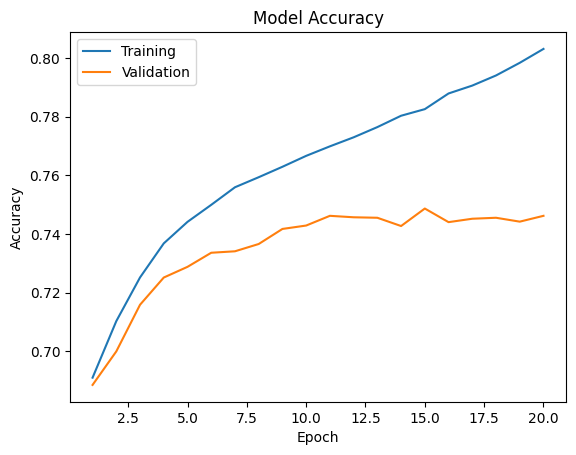

In [269]:
epoch_count = range(1, len(history.history['accuracy']) + 1)
plt.plot(epoch_count, history.history['accuracy'], label='Training')
plt.plot(epoch_count, history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [250]:
# Definir el modelo del encoder para la predicción
encoder_model = Model(encoder_input_layer, [encoder_state_short, encoder_state_long])

# Definir las capas para el decoder en el modo de predicción
decoder_input_word = Input(shape=(1,))
decoder_in = decoder_embedding_layer(decoder_input_word)
decoder_state_input = [Input(shape=(256,)), Input(shape=(256,))]

decoder_out, decoder_state_short, decoder_state_long = decoder(decoder_in, initial_state = decoder_state_input)
decoder_out = dense(decoder_out)

decoder_model = Model(
    [decoder_input_word] + decoder_state_input, 
    [decoder_out] + [decoder_state_short, decoder_state_long]
)

In [253]:
# Función para generar respuestas a preguntas utilizando el modelo entrenado
def answer_question(input_text):
    # Convertir el texto de entrada a una secuencia tokenizada y rellenarla
    sequence = tok_input.texts_to_sequences([input_text])[0]
    padded_sequence = pad_sequences([sequence], padding='post', maxlen=max_input_len)

    # Predecir los estados iniciales del encoder
    states_value = encoder_model.predict(padded_sequence)

    # Inicializar la secuencia objetivo con el token <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_output['<sos>']

    eos = word2idx_output['<eos>']

    output_sentence = []
    for _ in range(max_output_len):
        # Predecir el siguiente token en la secuencia
        output_tokens, short_mem, long_mem = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si se predice <eos>, terminar la secuencia
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados para la siguiente iteración
        states_value = [short_mem, long_mem]

        # Actualizar la secuencia objetivo con el nuevo token predicho
        target_seq[0, 0] = idx

    
    clear_output(wait=False)
    print('----Input----')
    print(input_text)
    print('----Output----')
    print(' '.join(output_sentence))

    return ' '.join(output_sentence)

In [254]:
answer = answer_question('Hello')

----Input----
Hello
----Output----
hello how are you


In [255]:
answer = answer_question('what do you like')

----Input----
what do you like
----Output----
i like to play video games


In [256]:
answer = answer_question('cats or dogs')

----Input----
cats or dogs
----Output----
i am not sure what you mean


In [257]:
answer = answer_question('do you read')

----Input----
do you read
----Output----
i do not know what to say


In [272]:
answer = answer_question('help me')

----Input----
help me
----Output----
i love to read


Para conversaciones que se repiten bastante, algunas respuestas salen bien pero sinceramente es muy 'cherry picking'. Para la gran mayoria de texto de entrada que uno ingresa al modelo, suele devolver texto que, mientras que si tiene sintaxis correcta, carece de coherencia.

Intenté entrenar modelos más complejos (con mas de una capa en encoder y decoder), pero solo logró aumentar significativamente los tiempos de entrenamiento. Posiblemente se requiere un dataset mas grande para poder mejorar los resultados.